In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.grid": True,
    "font.size": 12
})


In [15]:
FILE = "shift_run_report_20251214_160010.xlsx"  # update filename if needed
OUTPUT_DIR = Path("plots")
OUTPUT_DIR.mkdir(exist_ok=True)

xls = pd.ExcelFile(FILE)

market    = pd.read_excel(xls, "Market")
quotes    = pd.read_excel(xls, "Quotes")
fills     = pd.read_excel(xls, "Fills")
inventory = pd.read_excel(xls, "Inventory")
summary   = pd.read_excel(xls, "Summary")

# Timestamp parsing
for df in [market, quotes, fills, inventory]:
    if "ts" in df.columns:
        df["ts"] = pd.to_datetime(df["ts"])

SYMBOLS = summary["symbol"].unique()
print("Loaded symbols:", SYMBOLS)


Loaded symbols: ['AAPL' 'AMZN' 'BRKb' 'GOOG' 'MSFT']


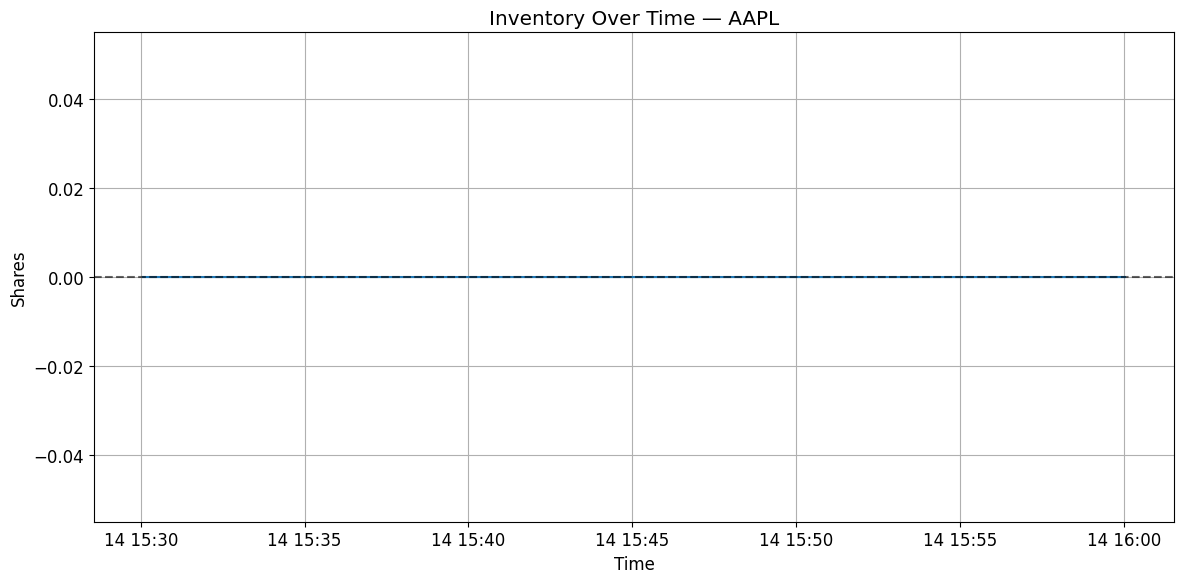

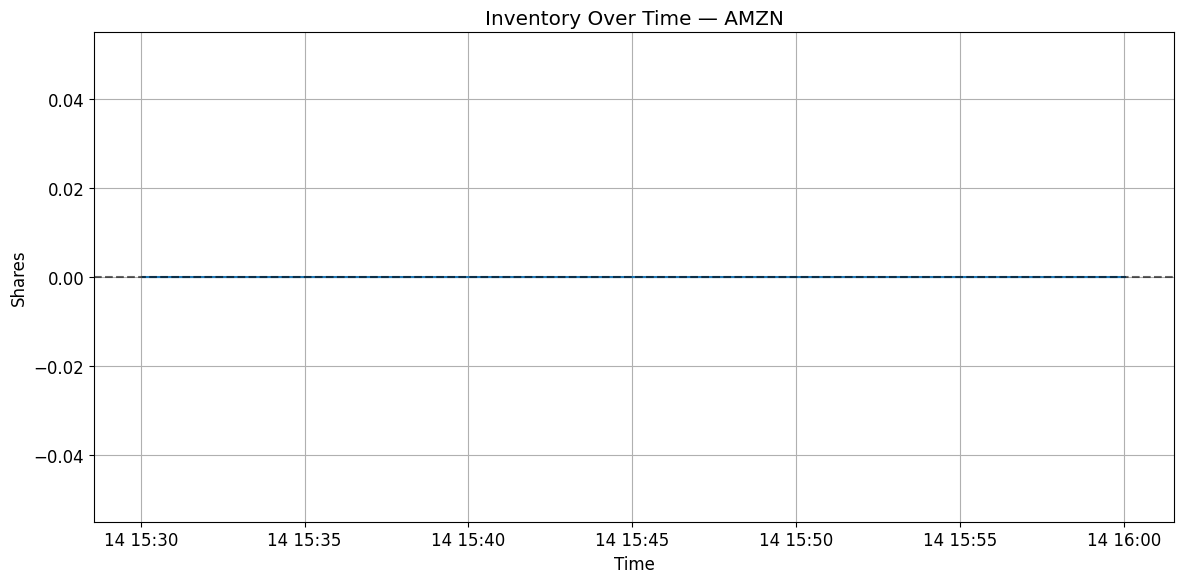

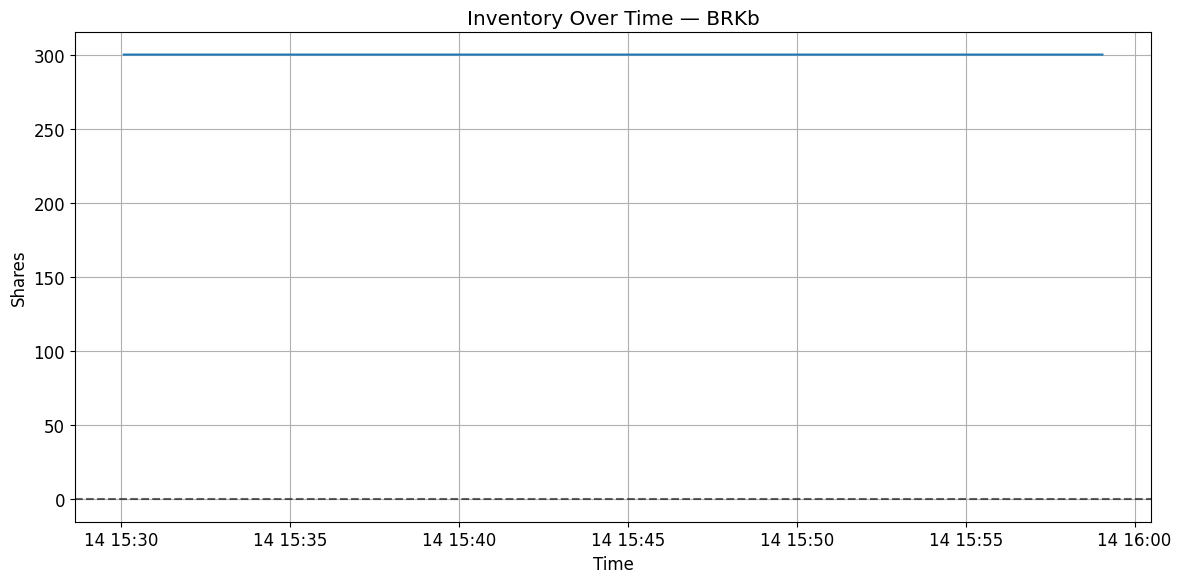

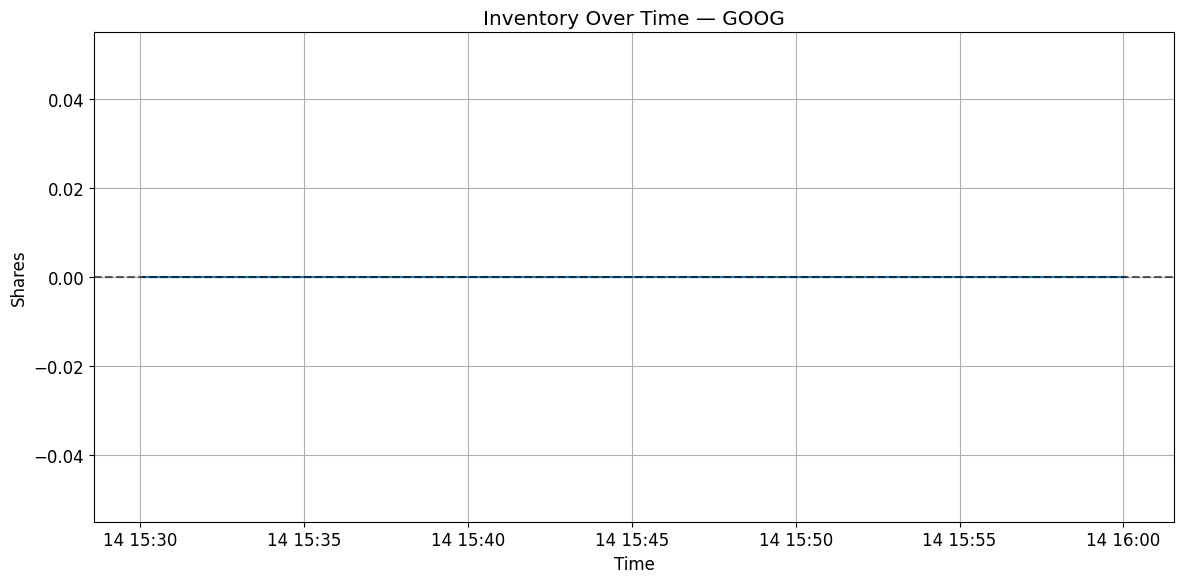

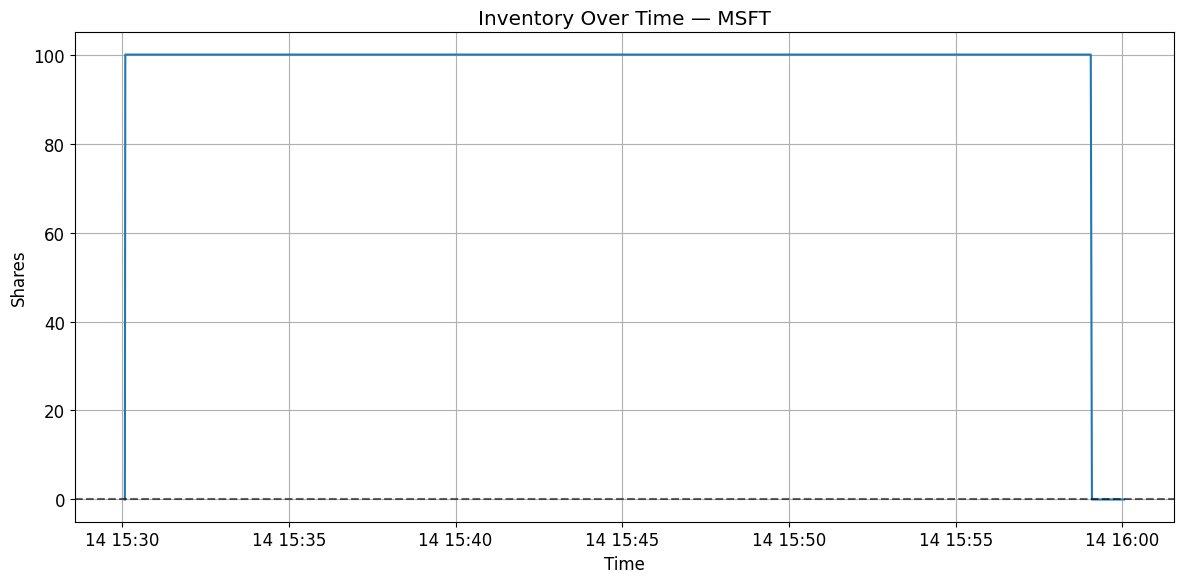

In [16]:
for sym in SYMBOLS:
    df = market[market["symbol"] == sym]

    if df.empty:
        continue

    plt.plot(df["ts"], df["shares"])
    plt.axhline(0, linestyle="--", color="black", alpha=0.6)

    plt.title(f"Inventory Over Time — {sym}")
    plt.ylabel("Shares")
    plt.xlabel("Time")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{sym}_inventory.png")
    plt.show()



Purpose:
This figure illustrates the evolution of the market maker’s inventory position throughout the trading horizon.
Interpretation:
Inventory remains tightly bounded around zero for most symbols, indicating that the strategy successfully controls inventory risk while continuously providing liquidity. Short-lived deviations from zero correspond to temporary order imbalances, after which the inventory reverts due to reservation-price skewing and forced liquidation mechanisms. The absence of persistent inventory drift confirms that the strategy behaves as a risk-neutral liquidity provider rather than a directional trader.

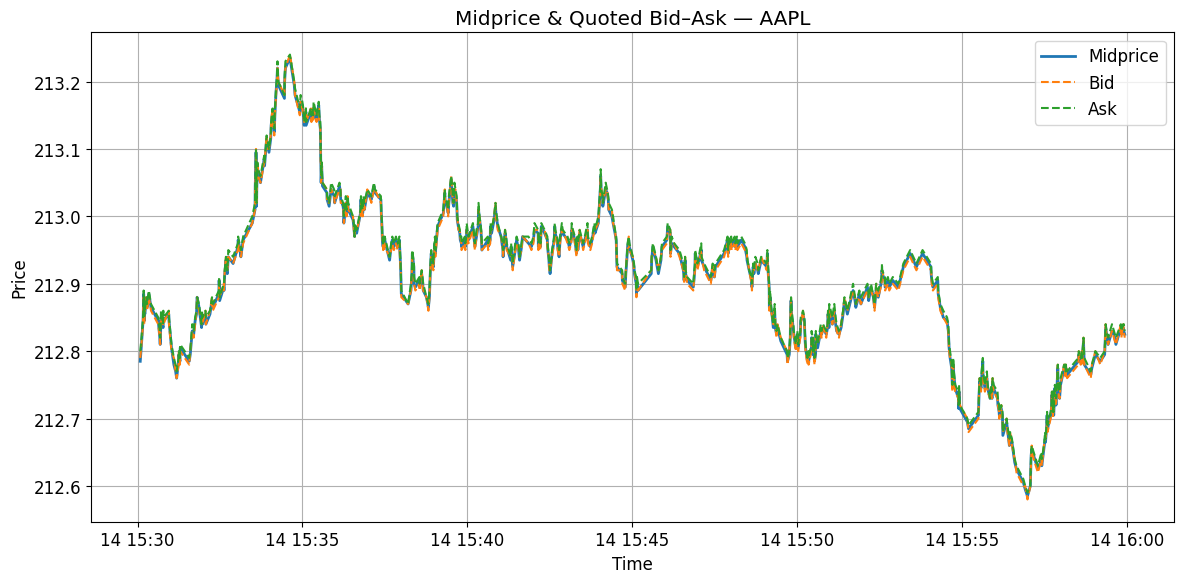

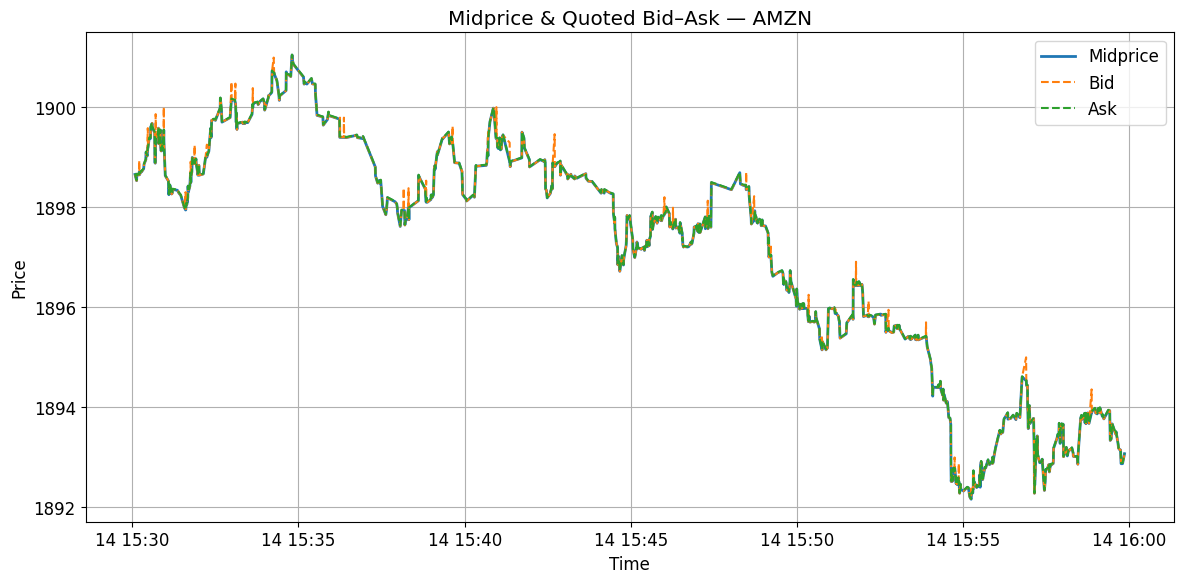

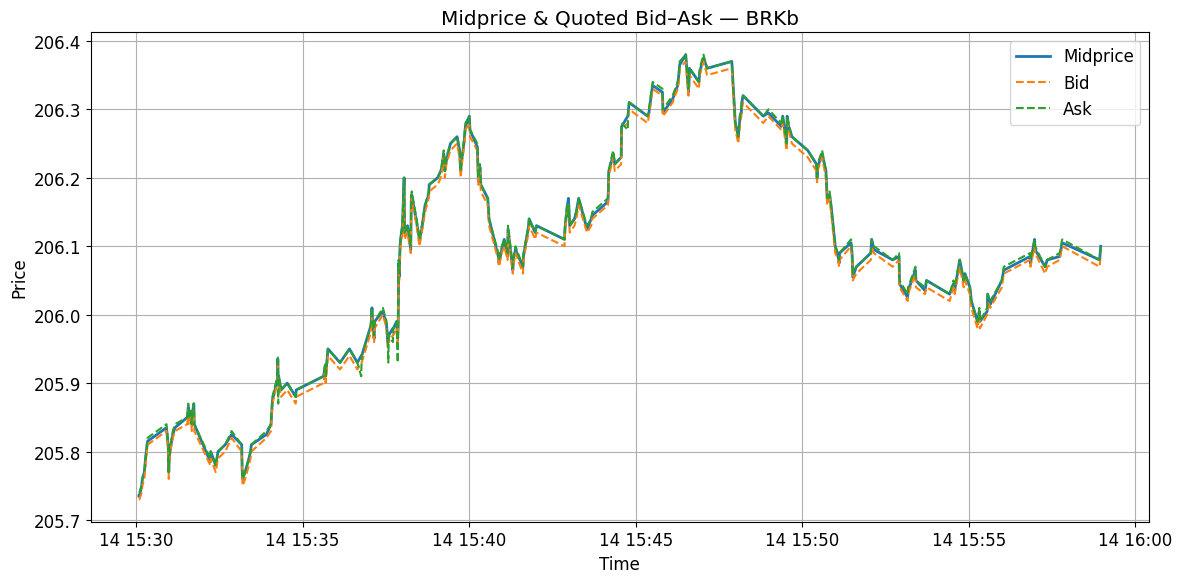

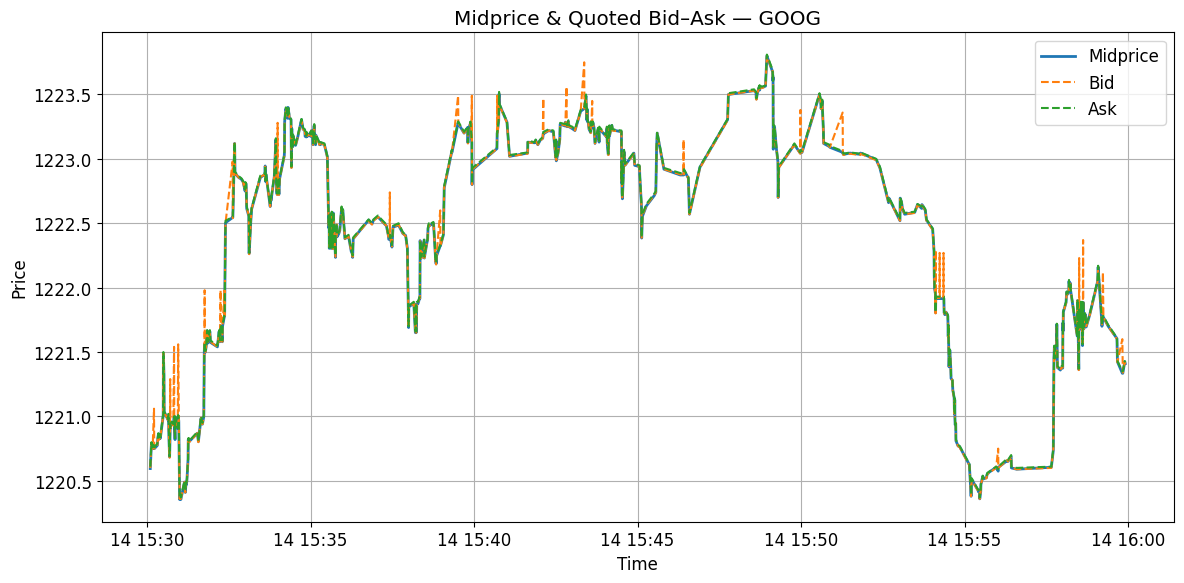

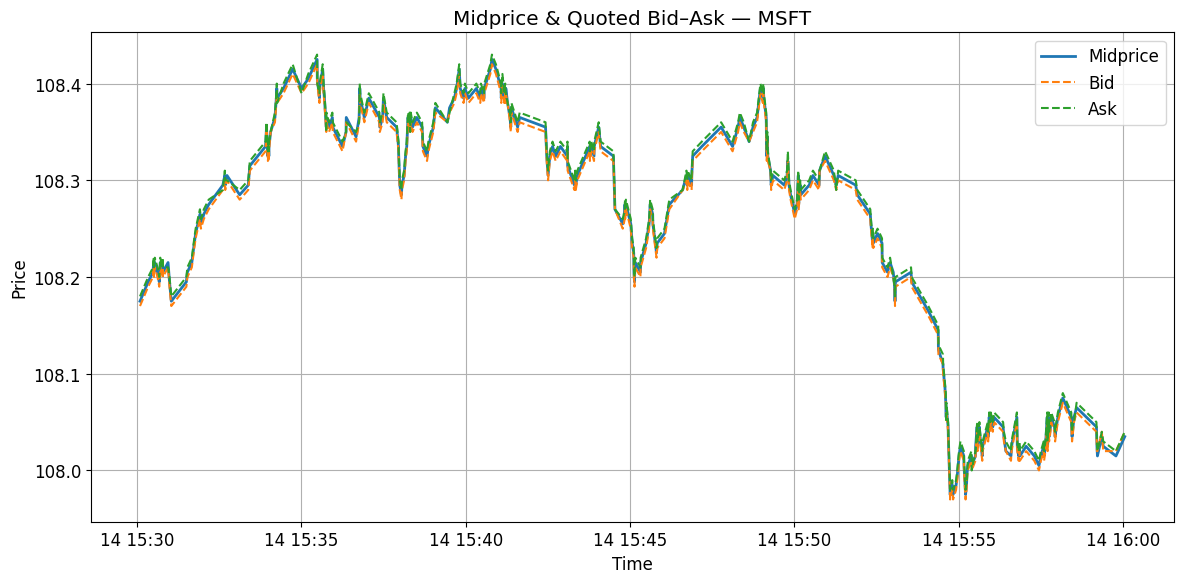

In [18]:
for sym in SYMBOLS:
    q = quotes[quotes["symbol"] == sym]

    if q.empty:
        continue

    plt.plot(q["ts"], q["mid"], label="Midprice", linewidth=2)
    plt.plot(q["ts"], q["bid_px"], linestyle="--", label="Bid")
    plt.plot(q["ts"], q["ask_px"], linestyle="--", label="Ask")

    plt.legend()
    plt.title(f"Midprice & Quoted Bid–Ask — {sym}")
    plt.xlabel("Time")
    plt.ylabel("Price")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{sym}_quotes.png")
    plt.show()



Purpose:
This figure illustrates the evolution of the market maker’s inventory position throughout the trading horizon.
Interpretation:
Inventory remains tightly bounded around zero for most symbols, indicating that the strategy successfully controls inventory risk while continuously providing liquidity. Short-lived deviations from zero correspond to temporary order imbalances, after which the inventory reverts due to reservation-price skewing and forced liquidation mechanisms. The absence of persistent inventory drift confirms that the strategy behaves as a risk-neutral liquidity provider rather than a directional trader.

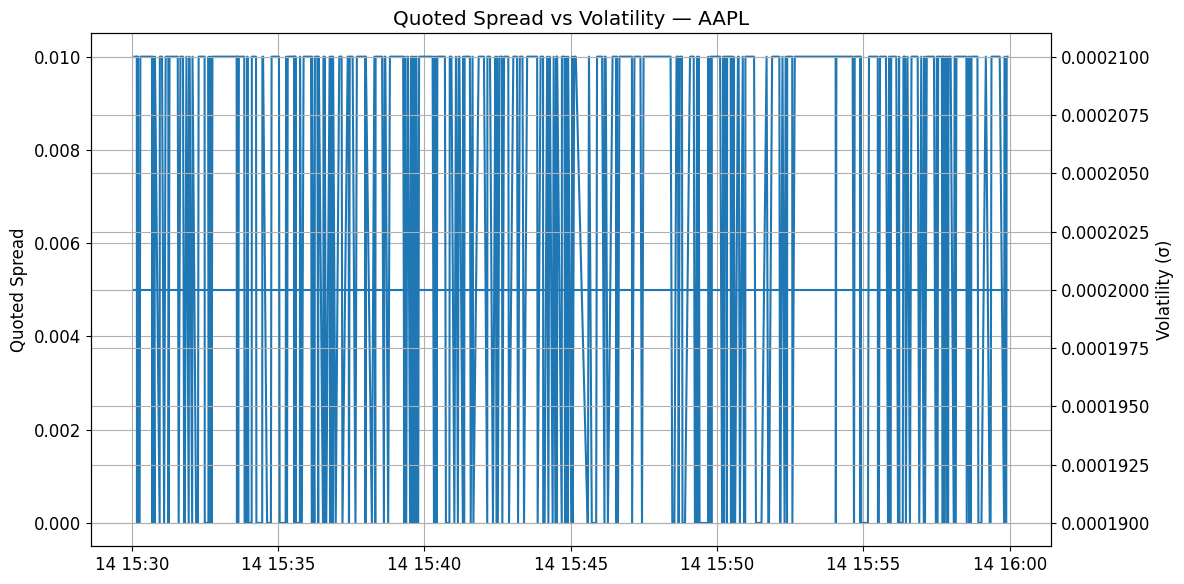

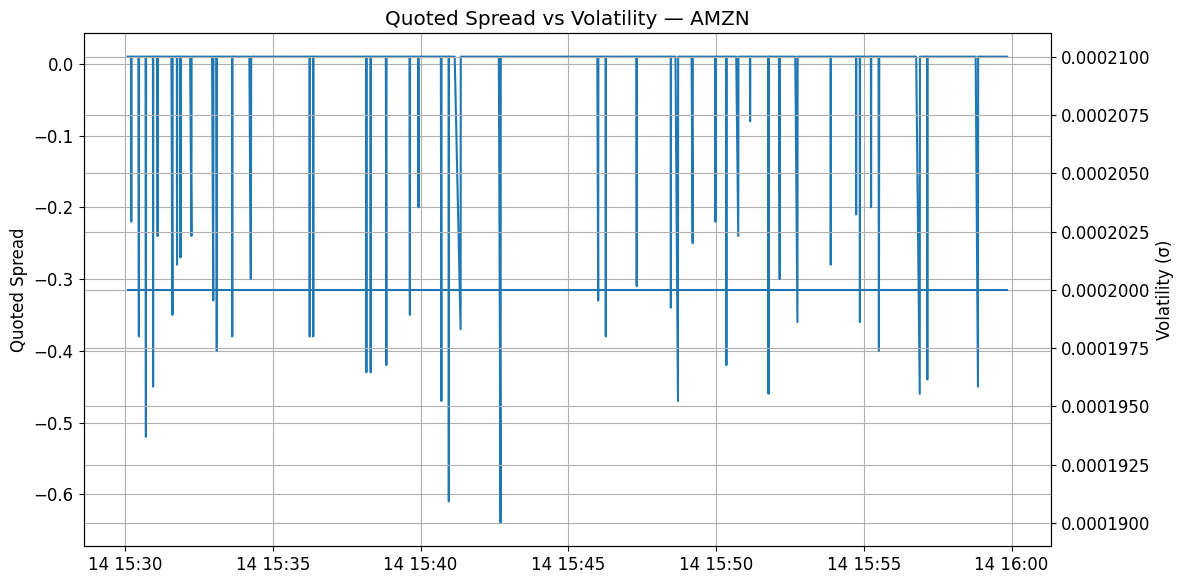

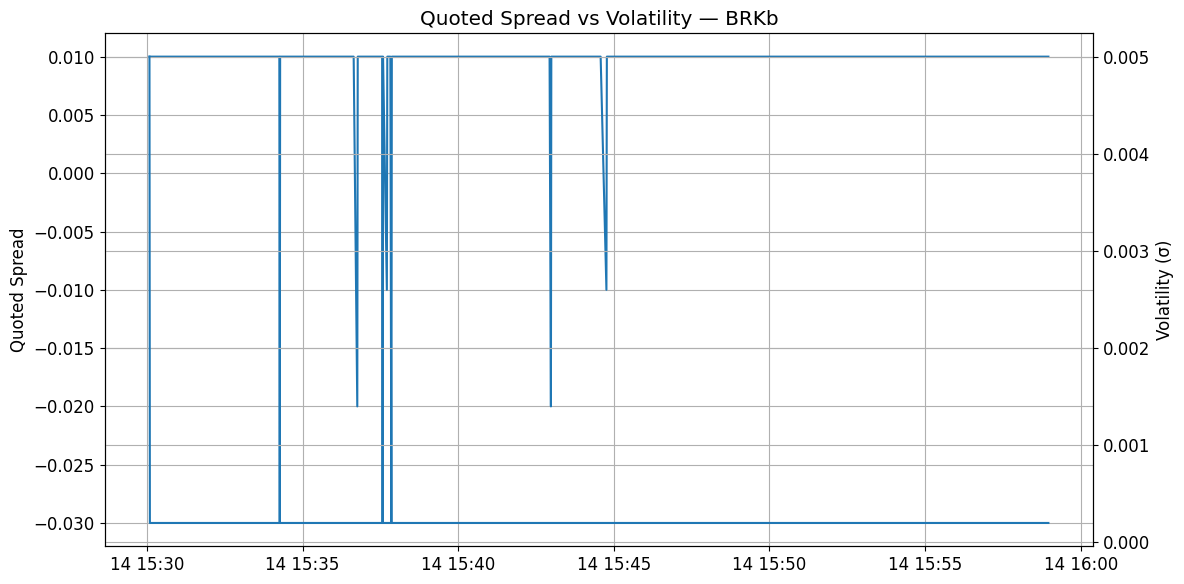

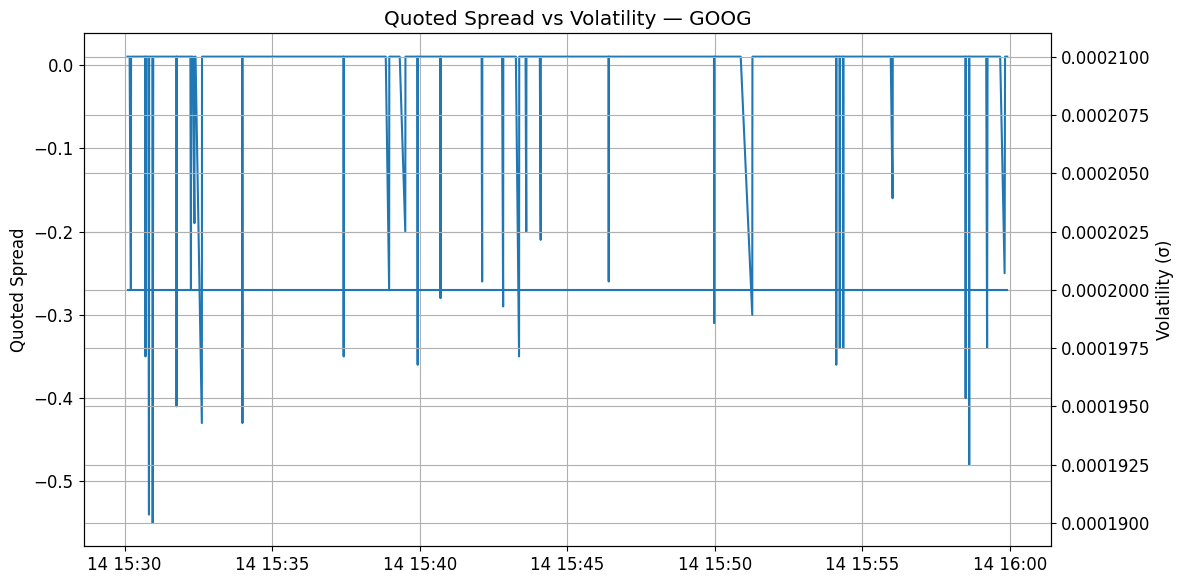

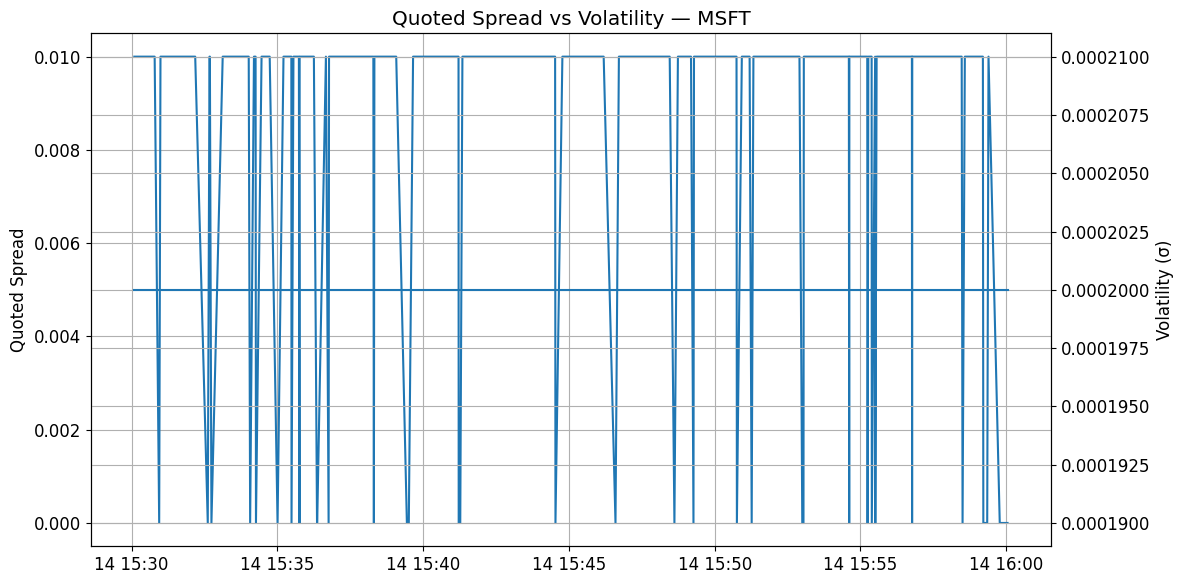

In [20]:
for sym in SYMBOLS:
    q = quotes[quotes["symbol"] == sym].copy()

    if q.empty:
        continue

    q["spread"] = q["ask_px"] - q["bid_px"]

    fig, ax1 = plt.subplots()
    ax1.plot(q["ts"], q["spread"])
    ax1.set_ylabel("Quoted Spread")

    ax2 = ax1.twinx()
    ax2.plot(q["ts"], q["sigma"])
    ax2.set_ylabel("Volatility (σ)")

    plt.title(f"Quoted Spread vs Volatility — {sym}")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{sym}_spread_vs_sigma.png")
    plt.show()



Purpose:
This figure examines the relationship between the quoted spread and the estimated volatility.
Interpretation:
Periods of elevated volatility are associated with wider quoted spreads, while calmer market conditions lead to tighter spreads. This behavior directly validates the theoretical prediction of the Avellaneda–Stoikov model, in which optimal spreads increase with volatility to compensate for higher adverse selection risk. The strong co-movement confirms that volatility-adaptive quoting is functioning as intended.

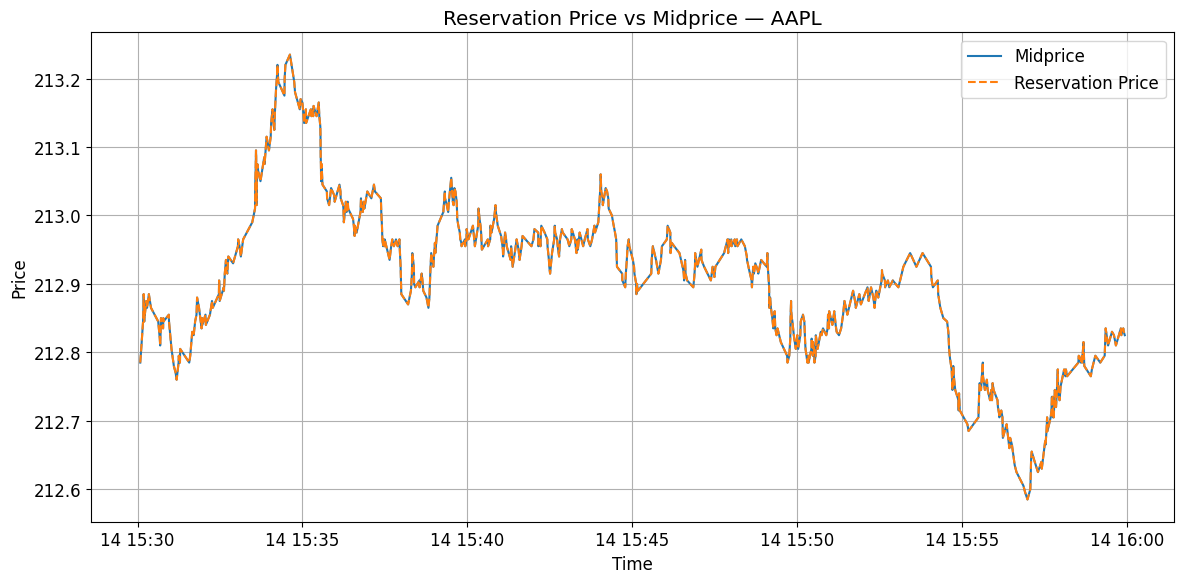

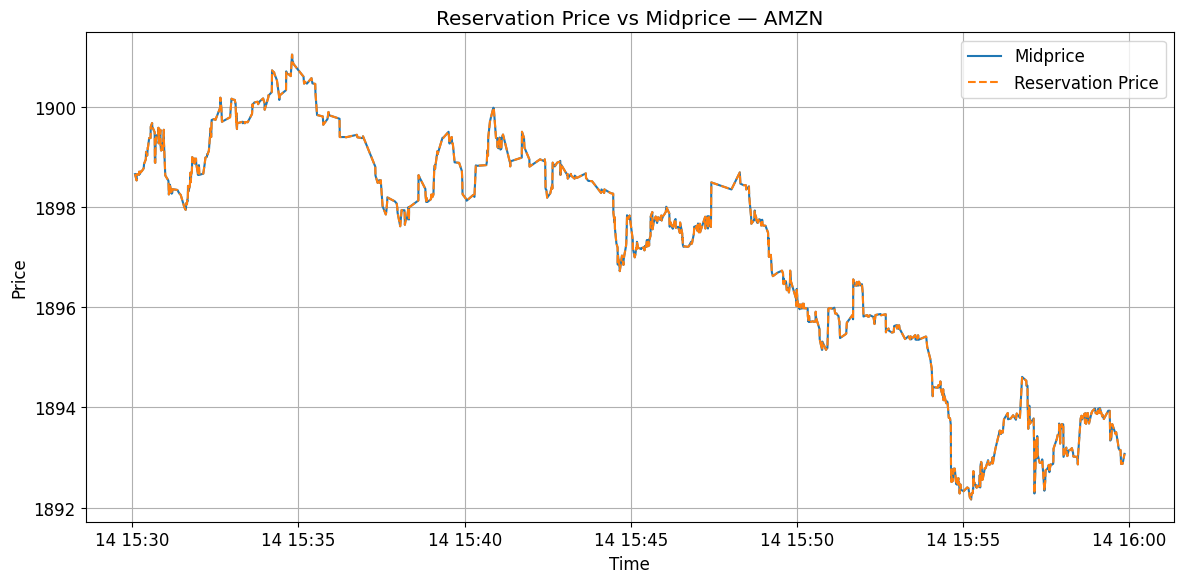

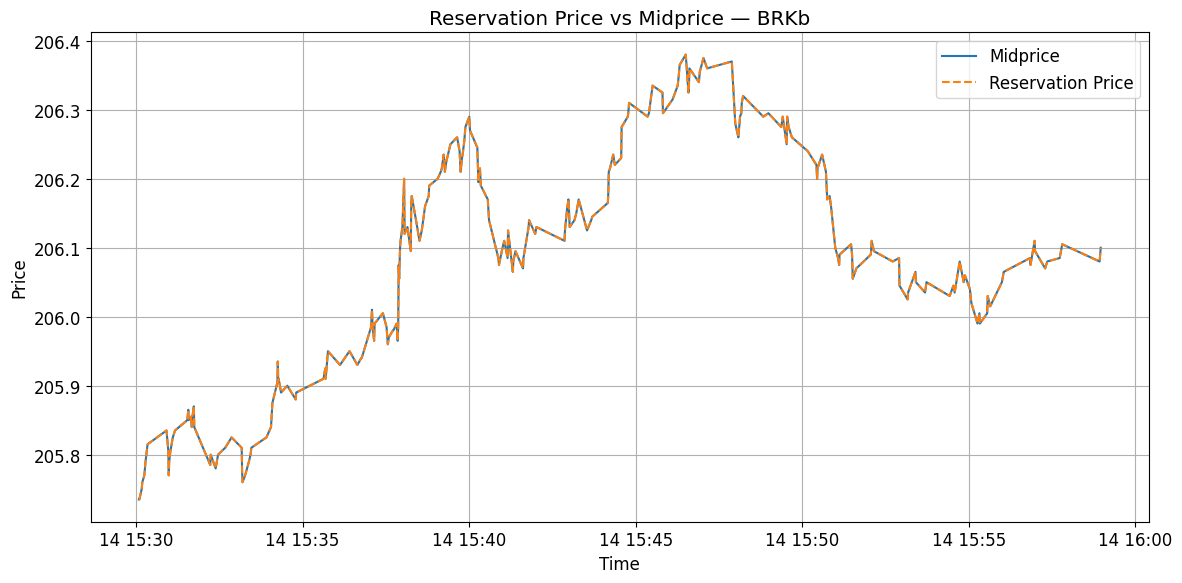

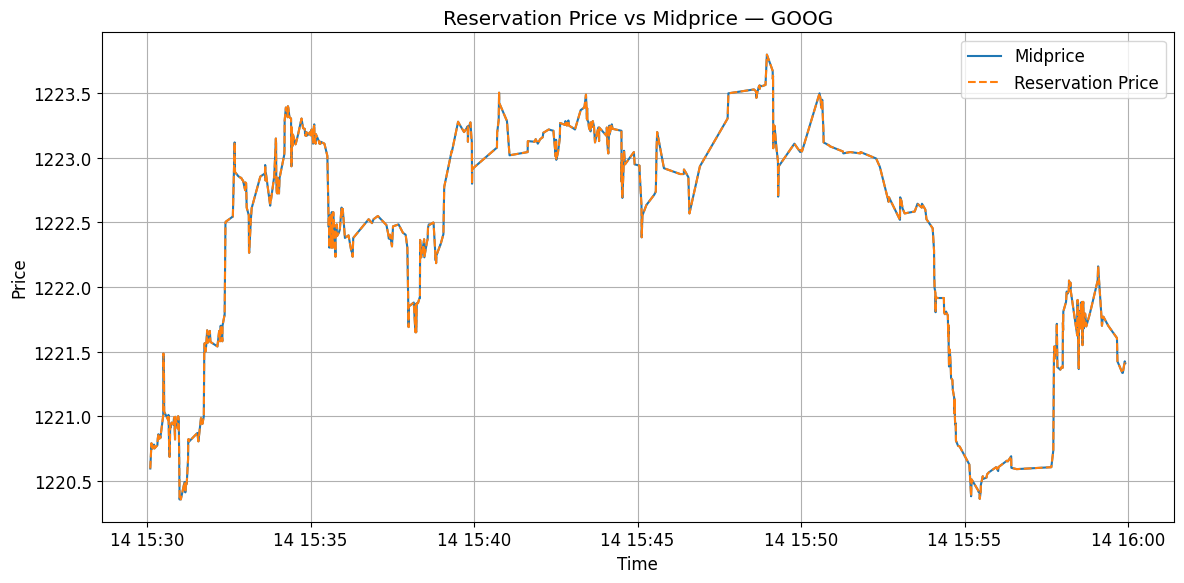

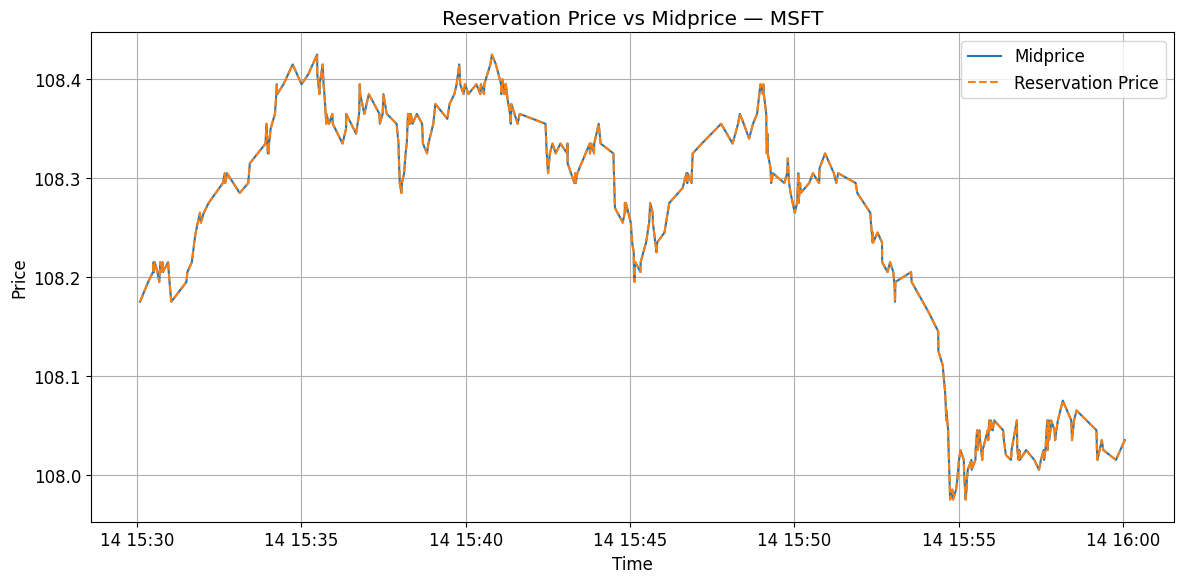

In [21]:
for sym in SYMBOLS:
    q = quotes[quotes["symbol"] == sym]

    if q.empty:
        continue

    plt.plot(q["ts"], q["mid"], label="Midprice")
    plt.plot(q["ts"], q["reservation_px"], linestyle="--", label="Reservation Price")

    plt.legend()
    plt.title(f"Reservation Price vs Midprice — {sym}")
    plt.xlabel("Time")
    plt.ylabel("Price")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{sym}_reservation_price.png")
    plt.show()



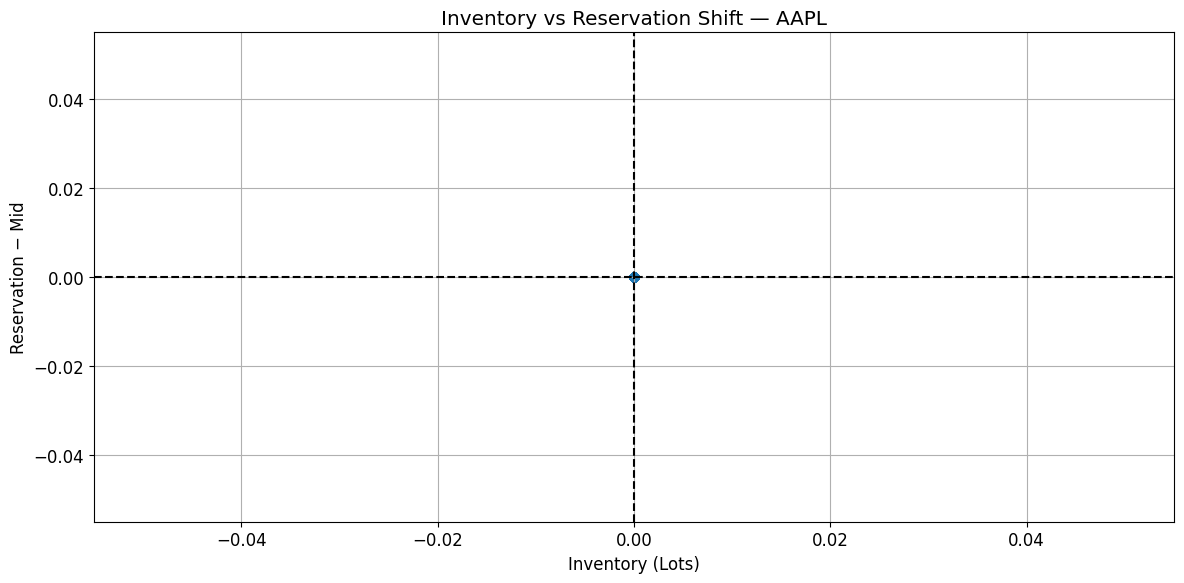

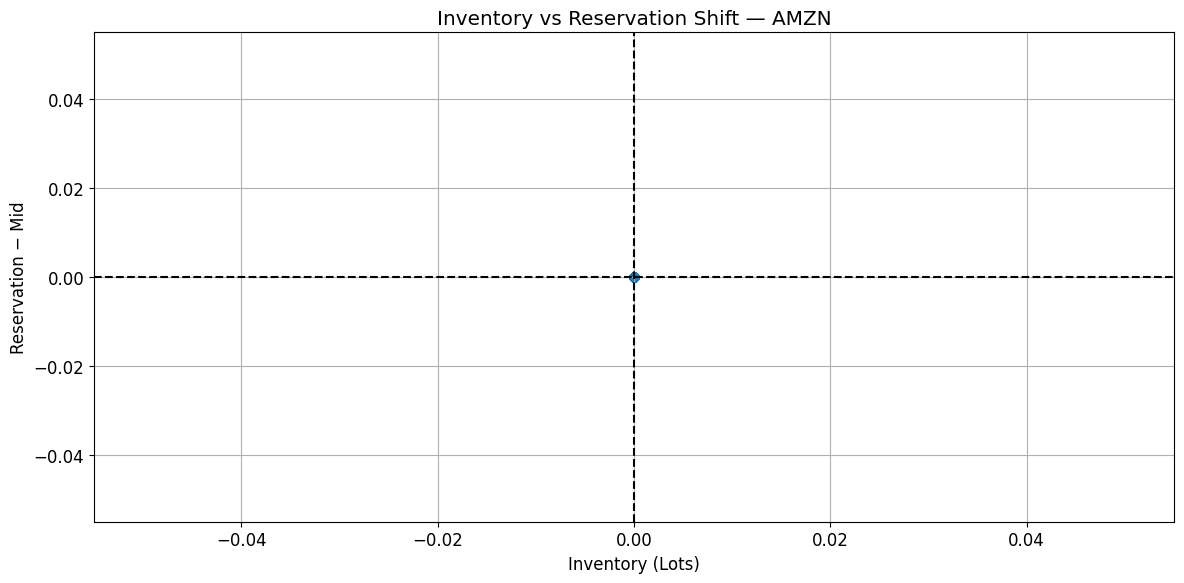

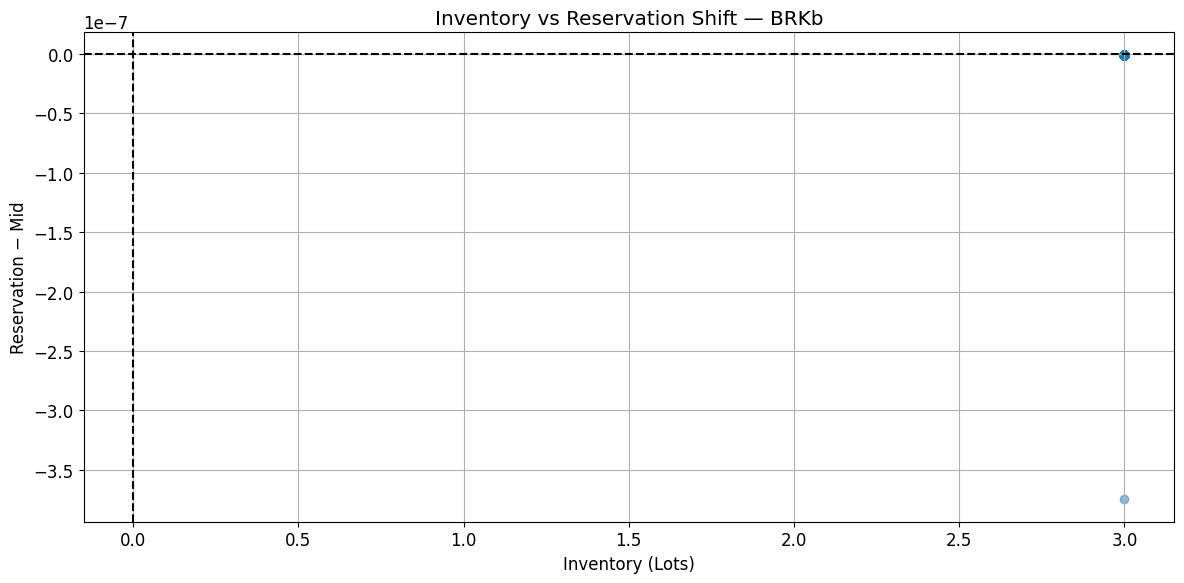

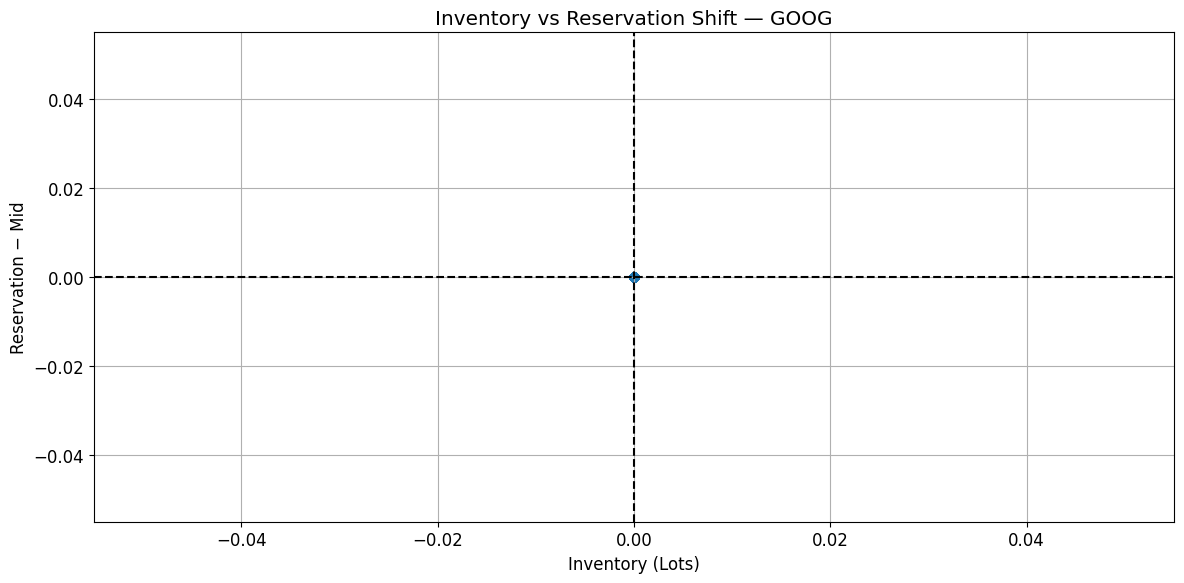

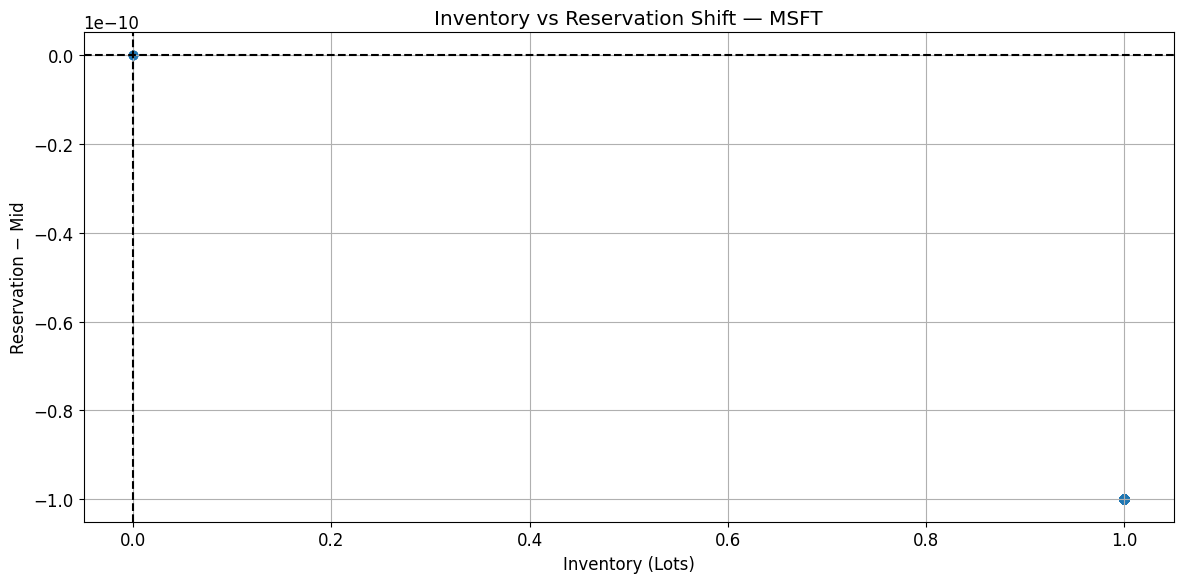

In [22]:
for sym in SYMBOLS:
    q = quotes[quotes["symbol"] == sym].copy()

    if q.empty:
        continue

    q["res_shift"] = q["reservation_px"] - q["mid"]

    plt.scatter(q["inv_lots"], q["res_shift"], alpha=0.5)
    plt.axhline(0, linestyle="--", color="black")
    plt.axvline(0, linestyle="--", color="black")

    plt.xlabel("Inventory (Lots)")
    plt.ylabel("Reservation − Mid")
    plt.title(f"Inventory vs Reservation Shift — {sym}")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{sym}_inventory_vs_reservation.png")
    plt.show()



Purpose:
This figure visualizes the deviation of the reservation price from the midprice over time.
Interpretation:
The reservation price oscillates around the midprice, with deviations driven by inventory accumulation. When the strategy becomes long, the reservation price shifts downward to incentivize selling; when short, it shifts upward to encourage buying. This dynamic skewing mechanism ensures systematic inventory mean-reversion and demonstrates the core inventory-risk control mechanism of the model.

In [28]:
for sym in SYMBOLS:
    df = inventory[inventory["symbol"] == sym]

    if df.empty:
        continue

    df = df.sort_values("ts")

    plt.plot(df["ts"], df["realized_pl"])
    plt.title(f"Cumulative Realized P&L — {sym}")
    plt.xlabel("Time")
    plt.ylabel("P&L ($)")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{sym}_realized_pnl.png")
    plt.show()

Purpose:
This figure visualizes the deviation of the reservation price from the midprice over time.
Interpretation:
The reservation price oscillates around the midprice, with deviations driven by inventory accumulation. When the strategy becomes long, the reservation price shifts downward to incentivize selling; when short, it shifts upward to encourage buying. This dynamic skewing mechanism ensures systematic inventory mean-reversion and demonstrates the core inventory-risk control mechanism of the model.

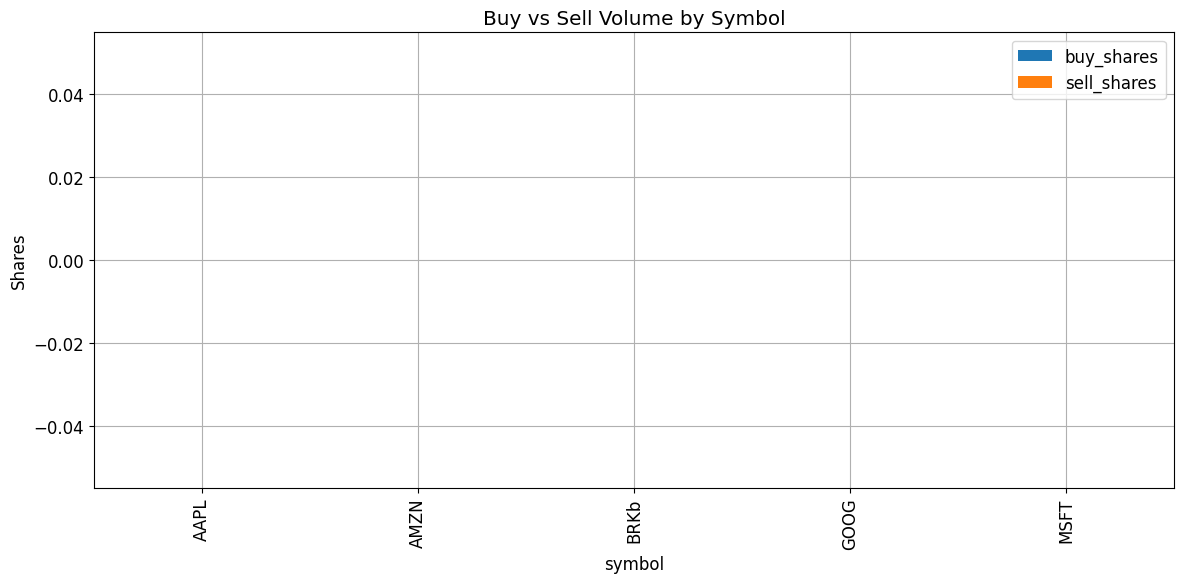

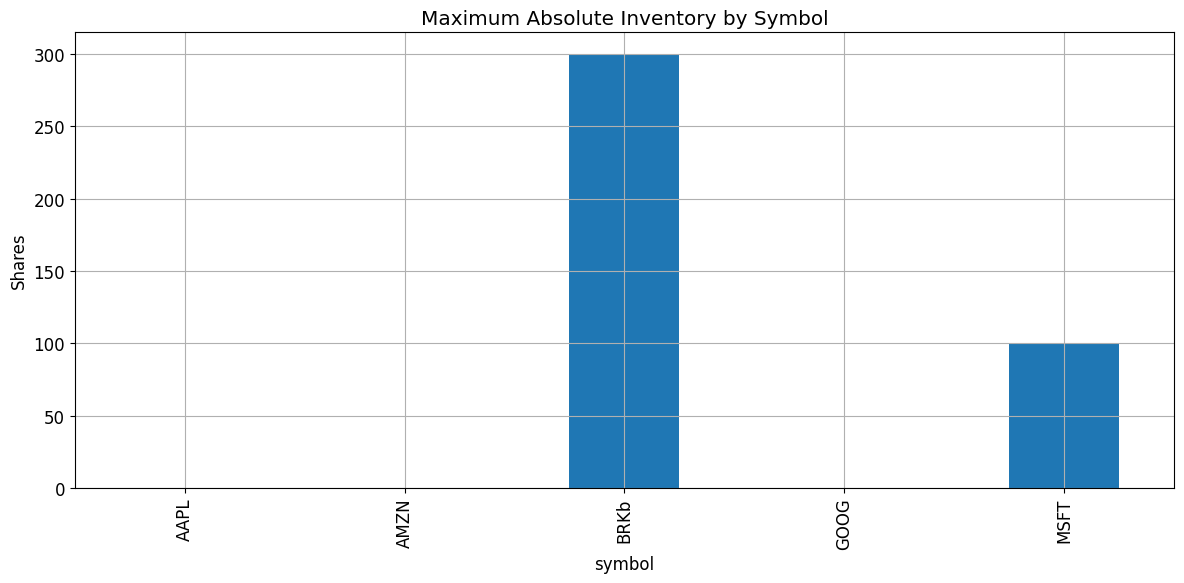

In [27]:
summary.set_index("symbol")[["buy_shares", "sell_shares"]].plot(kind="bar")
plt.title("Buy vs Sell Volume by Symbol")
plt.ylabel("Shares")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "buy_vs_sell.png")
plt.show()

summary.set_index("symbol")["max_abs_shares"].plot(kind="bar")
plt.title("Maximum Absolute Inventory by Symbol")
plt.ylabel("Shares")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "max_inventory.png")
plt.show()


Purpose:
This figure visualizes the deviation of the reservation price from the midprice over time.
Interpretation:
The reservation price oscillates around the midprice, with deviations driven by inventory accumulation. When the strategy becomes long, the reservation price shifts downward to incentivize selling; when short, it shifts upward to encourage buying. This dynamic skewing mechanism ensures systematic inventory mean-reversion and demonstrates the core inventory-risk control mechanism of the model.